In [12]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import ipywidgets as widgets

from torchvision.utils import save_image, make_grid

from scipy.spatial import cKDTree


In [13]:
# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [14]:
class diffusive_flow(nn.Module):
    def __init__(self):
        super(diffusive_flow, self).__init__()
        # self.t_range = t_range
        # self.embedding = nn.Embedding(t_range, 1)
        
        self.layers = nn.Sequential(
            nn.Linear(3, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 2),
        )
    
    def forward(self, data, t):
        x = data[0]
        y = data[1]
        embedded_t = self.embedding(torch.tensor(t))

        x_y = torch.tensor([x, y])
        concatenated = torch.cat((x_y, embedded_t), dim=0)

        out = self.layers(concatenated)
        return out

model = diffusive_flow()

In [24]:
# diffuse 관련 변수 및 함수 정의

def make_alpha_bars(min_beta, max_beta, t_range, device=device):
    betas = torch.linspace(min_beta, max_beta, t_range).to(device)
    alphas = 1 - betas

    return torch.tensor([torch.prod(alphas[:(i+1)]) for i in range(len(alphas))]).to(device)

def diffuse_x0(x0, t, alpha_bars, eta=None, device=device):
    if not isinstance(x0, torch.Tensor):
        x0 = torch.tensor(x0).to(device)
    else:
        x0 = x0.to(device)
        
    n, d = x0.shape
    a_bar = alpha_bars[t-1]

    if eta is None:
        eta = torch.randn(n, d).to(device)
    
    xT = a_bar.sqrt().view(-1,1) * x0 + (1 - a_bar).sqrt().view(-1,1) * eta

    return xT

In [16]:
# make vector field
def vector_field(vectors, scale=0.5):
    vf = vectors * scale
    return vf

In [17]:
# grid 생성
def make_grid(lim, n, device=device):
    x = np.linspace(-lim, lim, n)
    y = np.linspace(-lim, lim, n)
    X, Y = np.meshgrid(x, y)   # 20x20, 20x20
    X = X.reshape([-1,1])   # 20^2 x 1
    Y = Y.reshape([-1,1])   # 20^2 x 1

    grid_points = np.concatenate([X, Y], axis=1)
    return torch.tensor(grid_points, device=device, dtype=torch.float32)

grid_points = make_grid(5, 20)

In [18]:
def draw_data(data, lim=5, title_str='Data', color='blue'):
    if isinstance(data, torch.Tensor):
        data = data.cpu()

    plt.figure(figsize=(8, 6))
    plt.scatter(data[:,0], data[:,1], label='data', c=color, alpha=1)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel('X')
    plt.xlabel('Y')
    plt.title(title_str)
    plt.grid(True)
    plt.show()

In [19]:
def draw_vector_field(grid_points, vf, scale=5, color='blue', width=0.003, title='Vector Field'):
    if isinstance(grid_points, torch.Tensor):
        grid_points = grid_points.cpu().detach().numpy()
    if isinstance(vf, torch.Tensor):
        vf = vf.cpu().detach().numpy()
        
    X = grid_points[:, 0]
    Y = grid_points[:, 1]
    
    U = vf[:, 0]
    V = vf[:, 1]

    plt.figure(figsize=(8, 6))
    plt.quiver(X, Y, U, V, scale=scale, color=color, width=width)
    plt.xlabel('X')
    plt.xlabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [29]:
def make_training_data(grid_points, data, alpha_bars, t_range=200, max_distance=0.5, device=device):
    if not isinstance(data, torch.Tensor):
        x0 = torch.tensor(data).to(device)
    else:
        x0 = data.to(device)

    eta = torch.randn_like(x0).to(device)
    vector_fields = []
    xTs = []

    for t in range(t_range):
        xT = diffuse_x0(x0, t, alpha_bars, eta=eta)

        tree = cKDTree(x0.detach().cpu().numpy())

        if isinstance(grid_points, torch.Tensor):
            grid_points = grid_points.detach().cpu().numpy()

        avg_vecs = np.zeros_like(grid_points)

        for i, point in enumerate(grid_points):
            indices = tree.query_ball_point(point, r=max_distance)
            if len(indices) == 0:
                avg_vecs[i] = np.array([0.0, 0.0])
                continue
            neighbor_vecs = xT[indices].cpu().numpy() - x0[indices].cpu().numpy()

            avg_vec = neighbor_vecs.mean(axis=0)
            avg_vecs[i] = avg_vec

        vector_fields.append(avg_vecs.copy())
        xTs.append(xT.clone().detach().cpu().numpy())
    
    return xTs, vector_fields

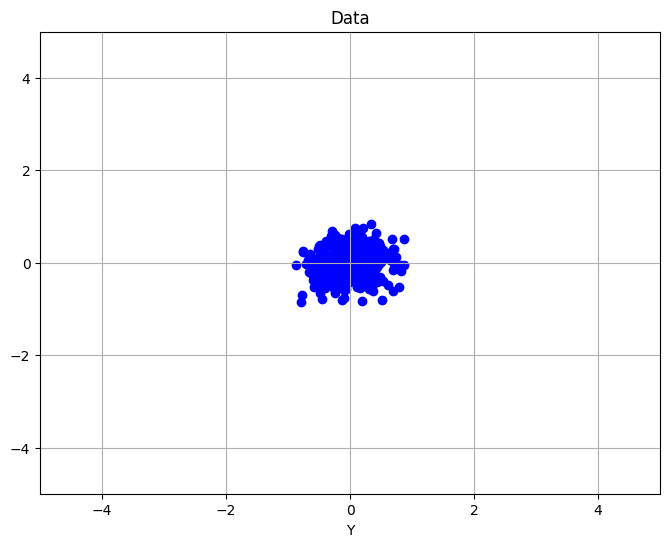

In [21]:
def make_sample_data_2d(mean, cov, datanum=200):
    data = np.random.multivariate_normal(mean, cov, datanum)
    data = np.array(data, dtype=np.float32)
    return data

datanum = 500
mean = np.array([0,0])
cov = np.array([[.1,.01], [.01,.1]])
data = torch.tensor(make_sample_data_2d(mean, cov, datanum))

lim = 5
draw_data(data, lim)

In [30]:
t_range = 500
min_beta = 1e-3
max_beta = 1e-1
alpha_bars = make_alpha_bars(min_beta, max_beta, t_range)

In [31]:
xTs, training_data = make_training_data(grid_points, data, alpha_bars, t_range=t_range)
for i, data in enumerate(training_data):
    training_data[i] = vector_field(data, scale=.3)

# draw_data(xTs[499], 4)

# # training data 저장
# np.savez('xTs_and_vfs.npz', xTs=xTs, training_data=training_data)

# # training data 로드
# loaded = np.load('xTs_and_vfs.npz')
# xTs = loaded['xTs']
# training_data = loaded['training_data']

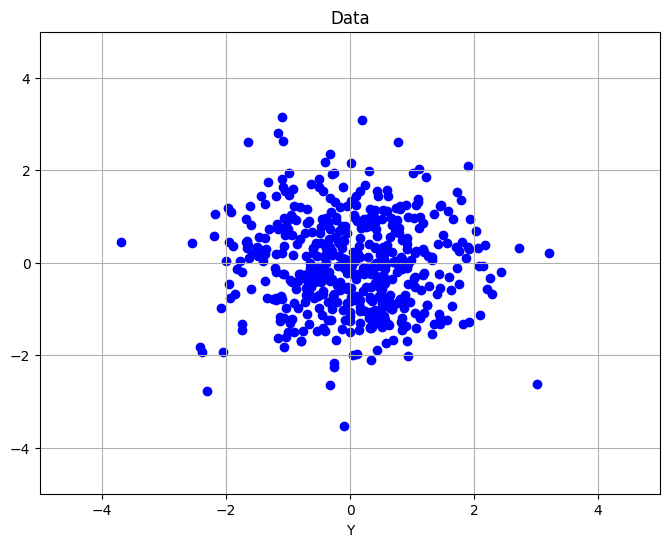

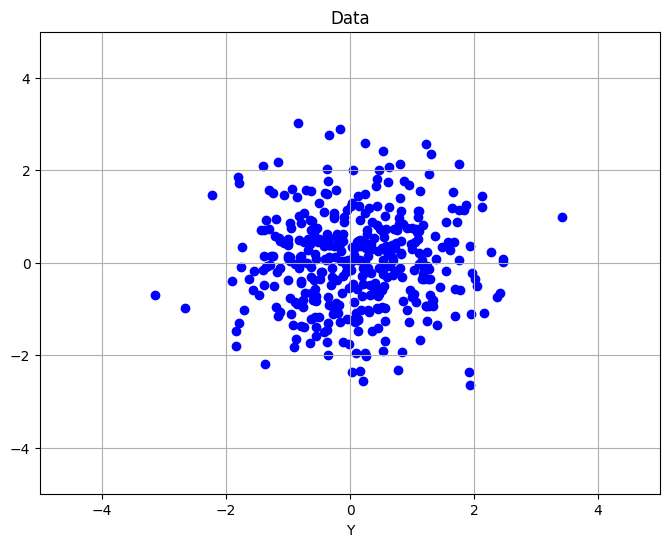

In [35]:
# draw_vector_field(grid_points, training_data[0], title='training_data1')
# draw_vector_field(grid_points, training_data[499], title='training_data1')

draw_data(xTs[0], 5)
x1 = diffuse_x0(data, 499, alpha_bars)
draw_data(x1, 5)

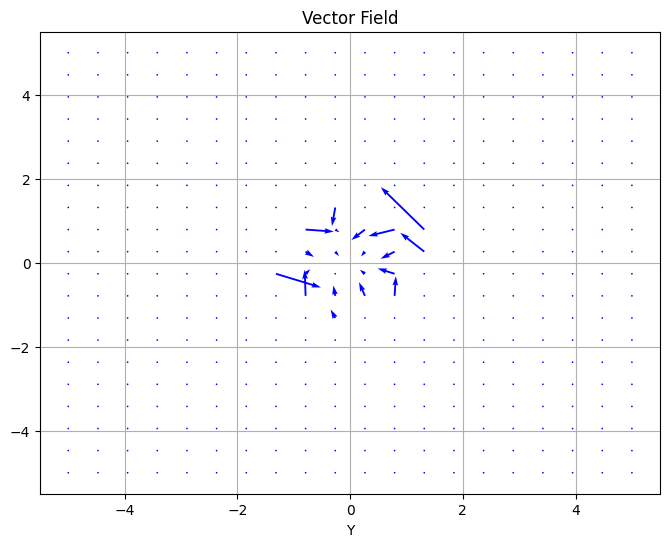

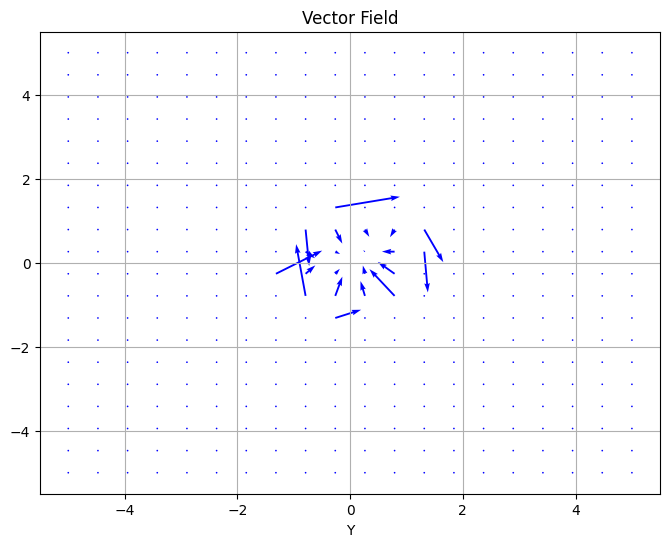

In [ ]:
# draw_data(data, 4)
# draw_data(xTs[0], 4)
# # draw_data(xTs[100], 4)
# # draw_data(xTs[200], 4)
# # draw_data(xTs[300], 4)
# # draw_data(xTs[400], 4)
# draw_data(xTs[499], 4)
draw_vector_field(grid_points, training_data[0])
draw_vector_field(grid_points, training_data[499])